In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple

#from Plot_tools import *
from File_tools import *

import pickle

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:


# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
in_dir  = "/scratch/wicker/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

# fv3_c1500  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C1500_kess", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
# fv3_c2000  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C2000_kess", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
#fv3_c2000_cp  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C2000_kess_cp", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

fv3_c2000_cpm  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C2000_kess_Cpm", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

# fv3_c2500  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C2500_kess", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
# fv3_c3000  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C3000_kess", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
# fv3_c3500  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C3500_kess", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
#fv3_c3500_cp  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C3500_kess_Cpm", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

fv3_c3500_cpm  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_SOLO_C3500_kess_Cpm", shear)), model_type='fv3_raw', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)


# with open('fv3_kess.pkl', 'wb') as f:
#     pickle.dump(dict(fv3_c1500=fv3_c1500, fv3_c2000=fv3_c2000, fv3_c2500=fv3_c2500, fv3_c3000=fv3_c3000, fv3_c3500=fv3_c3500, fv3_c2000_cp=fv3_c2000_cp, fv3_c3500_cp=fv3_c3500_cp), f)

# # CM1 #######

input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'

# cm1_c1500 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c1500_kess')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# cm1_c2000 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2000_kess')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# cm1_c2000_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2000_kess_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# cm1_c2500 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2500_kess')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# cm1_c3000 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3000_kess')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# cm1_c3500_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3500_kess_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# cm1_c3500 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3500_kess')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

# with open('cm1_kess.pkl', 'wb') as f:
#     pickle.dump(dict(cm1_c1500=cm1_c1500, cm1_c2000=cm1_c2000, cm1_c2500=cm1_c2500, cm1_c3000=cm1_c3000, cm1_c3500=cm1_c3500, cm1_c2000_eq1=cm1_c2000_eq1, cm1_c3500_eq1=cm1_c3500_eq1), f)

# # WRF ######

in_dir  = "/scratch/wicker/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

# wrf_c1500  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_C1500_kess", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# wrf_c2000  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_C2000_kess", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# wrf_c2500  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_C2500_kess", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# wrf_c3000  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_C3000_kess", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
# wrf_c3500  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_C3500_kess", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

# with open('wrf_kess.pkl', 'wb') as f:
#      pickle.dump(dict(wrf_c1500=wrf_c1500, wrf_c2000=wrf_c2000, wrf_c2500=wrf_c2500, wrf_c3000=wrf_c3000, wrf_c3500=wrf_c3500), f)


processing model run:  /scratch/wicker/ideal_updrafts/FV3_SOLO_C2000_kess_Cpm/shallow_12.5 

(60, 275)

 Number of selected updraft profiles:  275 
 Number of labeled objects:  297

Percentile value:  75.000000

Percentile value:  90.000000

Percentile value:  95.000000

processing model run:  /scratch/wicker/ideal_updrafts/FV3_SOLO_C3500_kess_Cpm/shallow_12.5 

(60, 802)

 Number of selected updraft profiles:  802 
 Number of labeled objects:  825

Percentile value:  75.000000

Percentile value:  90.000000

Percentile value:  95.000000



In [39]:
# Just read stuff back in...

del(fv3)
            
cm1 = pickle2Obj('cm1_kess.pkl')
wrf = pickle2Obj('wrf_kess.pkl')
fv3 = pickle2Obj('fv3_kess.pkl', retObj=False)

da = xr.DataArray(fv3)
print(da)

# for property, value in vars(cm1).items():
#     print(n)
#     if property.find("eq1") == -1:
#         print(np.asarray(value[0]).shape)
#     cm1_bin.append(value[0])

# a = np.asarray(cm1_bin)
# print(a.shape)

# Save stuff off....

# with open('fv3_kess.pkl', 'wb') as f:
#     pickle.dump( dict(fv3['fv3_c1500']=fv3_c1500, fv3['fv3_c2000']=fv3_c2000, fv3['fv3_c2500']=fv3_c2500, fv3['fv3_c3000']=fv3_c3000, fv3['fv3_c3500']=fv3_c3500, \
#                       fv3['fv3_c2000_cp']=fv3_c2000_cp, fv3['fv3_c3500_cp']=fv3_c3500_cp, c2000_cpm=fv3_c2000_cpm, c3500_cpm=fv3_c3500_cpm), f)




<xarray.DataArray ()>
array({'fv3_c1500': [array([[-1.1750308 , -1.0071338 , -0.99634665, ...,  0.4777145 ,
         0.48988125,  0.70422953],
       [-2.351717  , -1.6992683 , -1.581603  , ...,  0.99756414,
         1.0534211 ,  1.3003649 ],
       [-3.2270195 , -2.1749547 , -2.1660552 , ...,  1.564785  ,
         1.5767704 ,  1.665658  ],
       ...,
       [-2.535021  , -2.4540393 , -2.445512  , ...,  0.6670511 ,
         0.70590967,  1.1548555 ],
       [-2.3153574 , -2.2069805 , -2.1921642 , ...,  0.5827842 ,
         0.62366146,  1.3524727 ],
       [-2.081291  , -1.9573447 , -1.933366  , ...,  0.529698  ,
         0.6496895 ,  1.5311517 ]], dtype=float32), array([[-1.7320614e-03,  1.0123961e-03,  1.4337804e-03, ...,
         4.7771451e-01,  4.8988125e-01,  7.0422953e-01],
       [ 8.1773505e-02,  8.5097037e-02,  8.8352591e-02, ...,
         9.9756414e-01,  1.0534211e+00,  1.3003649e+00],
       [ 1.8144073e-01,  1.8342064e-01,  1.8619569e-01, ...,
         1.5647850e+00,  1.5767

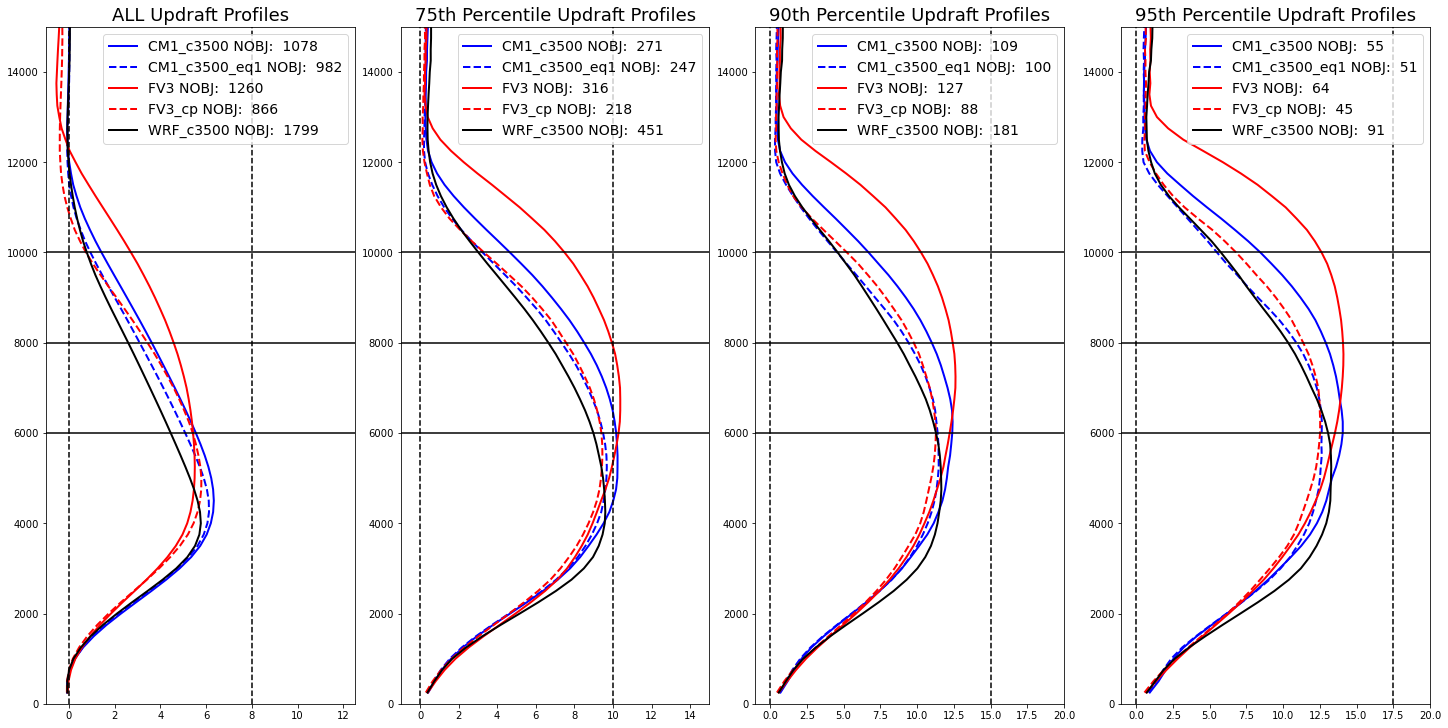

In [10]:
#--------------------------------------------------------------------------------------------
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)
#--------------------------------------------------------------------------------------------
# main

titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

zhgts = 250. + 250.*np.arange(60)

fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(20,10))

for n in np.arange(4):
                   
    plot_wprofile(cm1.cm1_c3500, zhgts, n, ax[n], 'b', 'CM1_c3500')              
    plot_wprofile(cm1.cm1_c3500_eq1, zhgts, n, ax[n], 'b', 'CM1_c3500_eq1', linestyle='dashed')
    plot_wprofile(fv3.fv3_c3500, zhgts, n, ax[n], 'r',    'FV3')
    plot_wprofile(fv3.fv3_c3500_cp, zhgts, n, ax[n], 'r', 'FV3_cp', linestyle='dashed')
    plot_wprofile(wrf.wrf_c3500, zhgts, n, ax[n], 'k', 'WRF_c3500')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)


plt.show()

Text(0.5, 0.98, 'CAPE=3500')

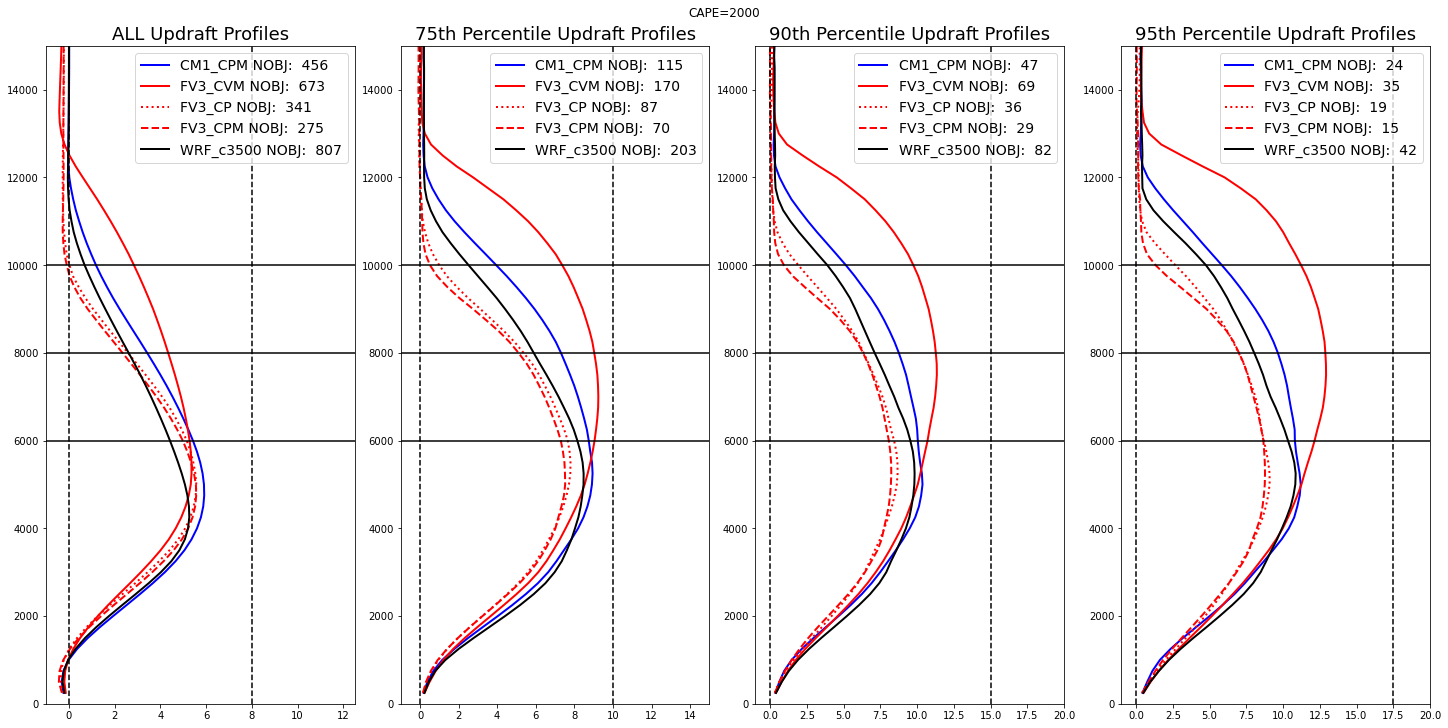

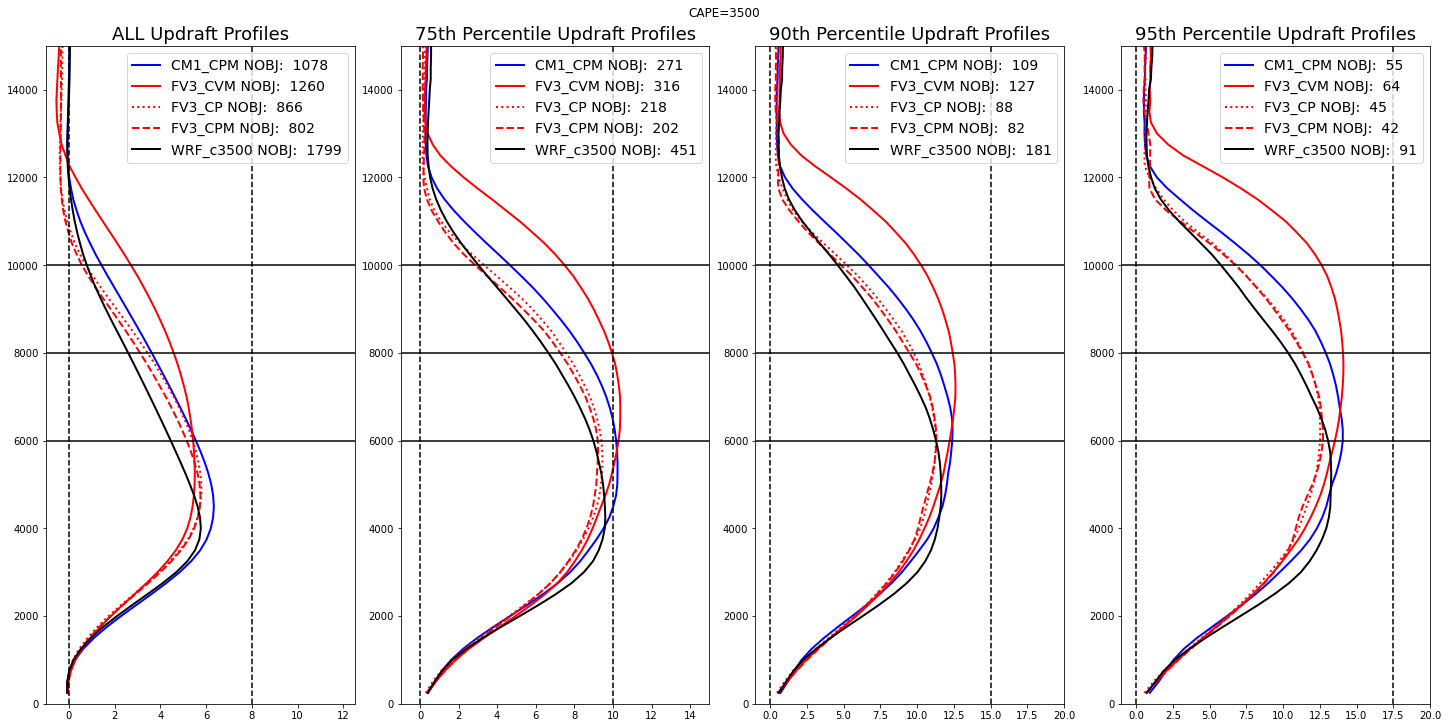

In [29]:
#--------------------------------------------------------------------------------------------
# main

titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

zhgts = 250. + 250.*np.arange(60)

fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(20,10))

for n in np.arange(4):
                   
    plot_wprofile(cm1.cm1_c2000, zhgts, n, ax[n], 'b', 'CM1_CPM')              
    #plot_wprofile(cm1.cm1_c2000_eq1, zhgts, n, ax[n], 'b', 'CM1_eq1', linestyle='dashed')
    plot_wprofile(fv3.fv3_c2000, zhgts, n, ax[n], 'r',    'FV3_CVM')
    plot_wprofile(fv3.fv3_c2000_cp, zhgts, n, ax[n], 'r', 'FV3_CP', linestyle='dotted')
    plot_wprofile(fv3_c2000_cpm, zhgts, n, ax[n], 'r', 'FV3_CPM', linestyle='dashed')
    plot_wprofile(wrf.wrf_c2000, zhgts, n, ax[n], 'k', 'WRF_c3500')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)

plt.suptitle("CAPE=2000")

#

fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(20,10))

for n in np.arange(4):
                   
    plot_wprofile(cm1.cm1_c3500, zhgts, n, ax[n], 'b', 'CM1_CPM')              
    #plot_wprofile(cm1.cm1_c3500_eq1, zhgts, n, ax[n], 'b', 'CM1_eq1', linestyle='dashed')
    plot_wprofile(fv3.fv3_c3500, zhgts, n, ax[n], 'r',    'FV3_CVM')
    plot_wprofile(fv3.fv3_c3500_cp, zhgts, n, ax[n], 'r',  'FV3_CP', linestyle='dotted')
    plot_wprofile(fv3_c3500_cpm, zhgts, n, ax[n], 'r', 'FV3_CPM', linestyle='dashed')
    plot_wprofile(wrf.wrf_c3500, zhgts, n, ax[n], 'k', 'WRF_c3500')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)

plt.suptitle("CAPE=3500")

In [ ]:

    
titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

for n in np.arange(len(wrf_q11)):
                   
    fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

    # WRF
    
    plot_wprofile(wrf_q11, zhgts, n, ax[0], 'y', 'WRF_Q11')
    plot_wprofile(wrf_q12, zhgts, n, ax[0], 'c', 'WRF_Q12')
    plot_wprofile(wrf_q13, zhgts, n, ax[0], 'g', 'WRF_Q13')
    plot_wprofile(wrf_q14, zhgts, n, ax[0], 'k', 'WRF_Q14')
    plot_wprofile(wrf_q15, zhgts, n, ax[0], 'r', 'WRF_Q15')
    plot_wprofile(wrf_q16, zhgts, n, ax[0], 'b', 'WRF_Q16')
    ax[0].set_title("WRF %s" % titles[n], fontsize=18)
    ax[0].axhline(y=6000., color='k', linestyle='-')
    ax[0].axhline(y=8000., color='k', linestyle='-')
    ax[0].axhline(y=10000., color='k', linestyle='-')
    ax[0].axvline(x=xvert[n], color='k', linestyle='--')
    ax[0].set_ylim(0.0,15000.)
    ax[0].set_xlim(-1.0,xlim[n])
    ax[0].legend(fontsize=14)

    # FV3

    plot_wprofile(fv3_q11, zhgts, n, ax[1], 'y', 'FV3_Q11')
    plot_wprofile(fv3_q12, zhgts, n, ax[1], 'c', 'FV3_Q12')
    plot_wprofile(fv3_q13, zhgts, n, ax[1], 'g', 'FV3_Q13')
    plot_wprofile(fv3_q14, zhgts, n, ax[1], 'k', 'FV3_Q14')
    plot_wprofile(fv3_q15, zhgts, n, ax[1], 'r', 'FV3_Q15')
    plot_wprofile(fv3_q16, zhgts, n, ax[1], 'b', 'FV3_Q16')
    ax[1].set_title("FV3 %s" % titles[n], fontsize=18)
    ax[1].axhline(y=6000., color='k', linestyle='-')
    ax[1].axhline(y=8000., color='k', linestyle='-')
    ax[1].axhline(y=10000., color='k', linestyle='-')
    ax[1].axvline(x=xvert[n], color='k', linestyle='--')
    
    ax[1].set_ylim(0.0,15000.)
    ax[1].set_xlim(-1.0,xlim[n])
    ax[1].legend(fontsize=14)

    # CM1

    plot_wprofile(cm1_q11, zhgts, n, ax[2], 'y', 'CM1_Q11')
    plot_wprofile(cm1_q12, zhgts, n, ax[2], 'c', 'CM1_Q12')
    plot_wprofile(cm1_q13, zhgts, n, ax[2], 'g', 'CM1_Q13')
    plot_wprofile(cm1_q14, zhgts, n, ax[2], 'k', 'CM1_Q14')
    plot_wprofile(cm1_q15, zhgts, n, ax[2], 'r', 'CM1_Q15')
    plot_wprofile(cm1_q16, zhgts, n, ax[2], 'b', 'CM1_Q16')
    ax[2].set_title("CM1 %s" % titles[n], fontsize=18)
    ax[2].axhline(y=6000., color='k', linestyle='-')
    ax[2].axhline(y=8000., color='k', linestyle='-')
    ax[2].axhline(y=10000., color='k', linestyle='-')
    ax[2].axvline(x=xvert[n], color='k', linestyle='--')

    ax[2].set_ylim(0.0,15000.)
    ax[2].set_xlim(-1.0,xlim[n])
    ax[2].legend(fontsize=14)


    plt.show()

In [ ]:
w_thresh = 5.0
cref_thresh = 45.
percent = (75,90,95)

# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_km4_dt15_thomp", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)


fv3_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14_thomp", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
fv3_qv14_thomp_ttend  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14_thomp_ttend", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

In [ ]:
# # WRF ######

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf_q14_nssl  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv14", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

# fv3_q14  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
# fv3_q15  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv15", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
# fv3_q16  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv16", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

In [ ]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

for n in np.arange(len(wrf_qv14_thomp)):
                   
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))

    plot_wprofile(wrf_qv14_thomp, zhgts, n, ax, 'k', 'WRF_Q14_Thomp')

    plot_wprofile(fv3_qv14_thomp, zhgts, n, ax, 'r', 'FV3_Q14_Thomp')
#plot_wprofile(fv3_qv14_thomp_ttend, zhgts, n, ax, 'c', 'FV3_Q14_Thomp_TTEND')
    ax.set_title("Thompson Runs %s" % titles[n], fontsize=18)
    ax.axhline(y=6000., color='k', linestyle='-')
    ax.axhline(y=8000., color='k', linestyle='-')
    ax.axhline(y=10000., color='k', linestyle='-')
    ax.axvline(x=xvert[n], color='k', linestyle='--')
    
    ax.set_ylim(0.0,15000.)
    ax.set_xlim(-1.0,xlim[n])
    ax.legend(fontsize=14)

In [ ]:
w_thresh = 5.0
cref_thresh = 45.
percent = (75,90,95)

# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_km4_dt15_thomp", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

fv3_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14_thomp", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

fv3_qv14_gfdl  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_gfdl", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

In [ ]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

for n in np.arange(len(wrf_qv14_thomp)):
                   
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))

    plot_wprofile(wrf_qv14_thomp, zhgts, n, ax, 'k', 'WRF_Q14_Thomp')

    plot_wprofile(fv3_qv14_thomp, zhgts, n, ax, 'r', 'FV3_Q14_Thomp')

    plot_wprofile(fv3_qv14_gfdl, zhgts, n, ax, 'c', 'FV3_Q14_GFDL')
    ax.set_title("Thompson + GFDL Microphysics Runs %s" % titles[n], fontsize=18)
    ax.axhline(y=6000., color='k', linestyle='-')
    ax.axhline(y=8000., color='k', linestyle='-')
    ax.axhline(y=10000., color='k', linestyle='-')
    ax.axvline(x=xvert[n], color='k', linestyle='--')
    
    ax.set_ylim(0.0,15000.)
    ax.set_xlim(-1.0,xlim[n])
    ax.legend(fontsize=14)

In [19]:
input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'
w_thresh = 5.0
cref_thresh = 45.
percent = (0,50,90)

cm1_c1500_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c1500_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c1500_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c1500_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c2000_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2000_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c2000_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2000_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c2500_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2500_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c2500_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2500_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c3000_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3000_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c3000_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3000_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c3500_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3500_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c3500_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3500_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)


with open('cm1_thom.pkl', 'wb') as f:
     pickle.dump(dict(c1500_thom=cm1_c1500_thom, c1500_thom_eq1=cm1_c1500_thom_eq1, 
                      c2000_thom=cm1_c2000_thom, c2000_thom_eq1=cm1_c2000_thom_eq1, 
                      c2500_thom=cm1_c2500_thom, c2500_thom_eq1=cm1_c2500_thom_eq1, 
                      c3000_thom=cm1_c3000_thom, c3000_thom_eq1=cm1_c3000_thom_eq1, 
                      c3500_thom=cm1_c3500_thom, c3500_thom_eq1=cm1_c3500_thom_eq1), f)



processing model run:  /scratch/wicker/cm1r20.3/run/squall_c1500_thom 


Reading existing DBZ file in directory
(60, 143)

 Number of selected updraft profiles:  143 
 Number of labeled objects:  166

Percentile value:  0.000000

Percentile value:  50.000000

Percentile value:  90.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_c1500_thom_eq1 


Reading existing DBZ file in directory
(60, 126)

 Number of selected updraft profiles:  126 
 Number of labeled objects:  149

Percentile value:  0.000000

Percentile value:  50.000000

Percentile value:  90.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_c2000_thom 


Reading existing DBZ file in directory
(60, 379)

 Number of selected updraft profiles:  379 
 Number of labeled objects:  402

Percentile value:  0.000000

Percentile value:  50.000000

Percentile value:  90.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_c2000_thom_eq1 


Reading existing DBZ file in directory
(60, 340)


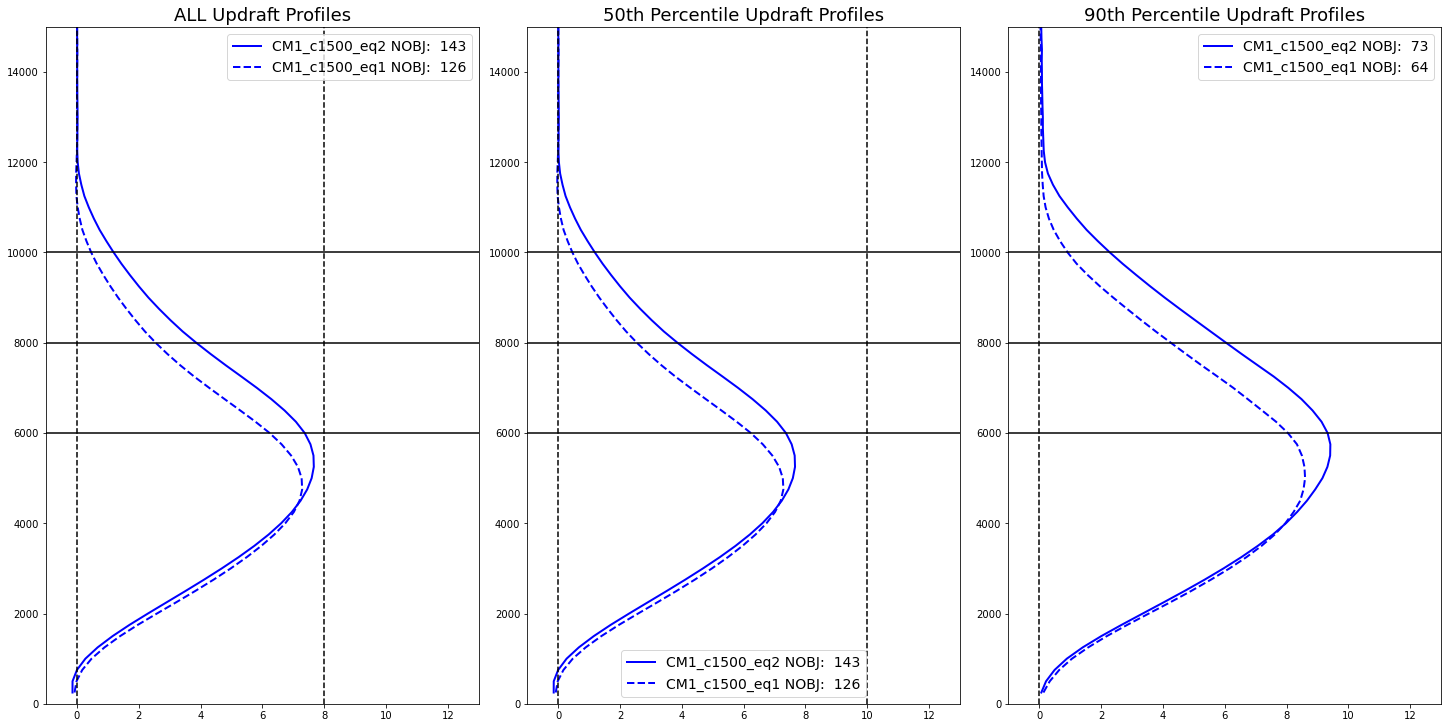

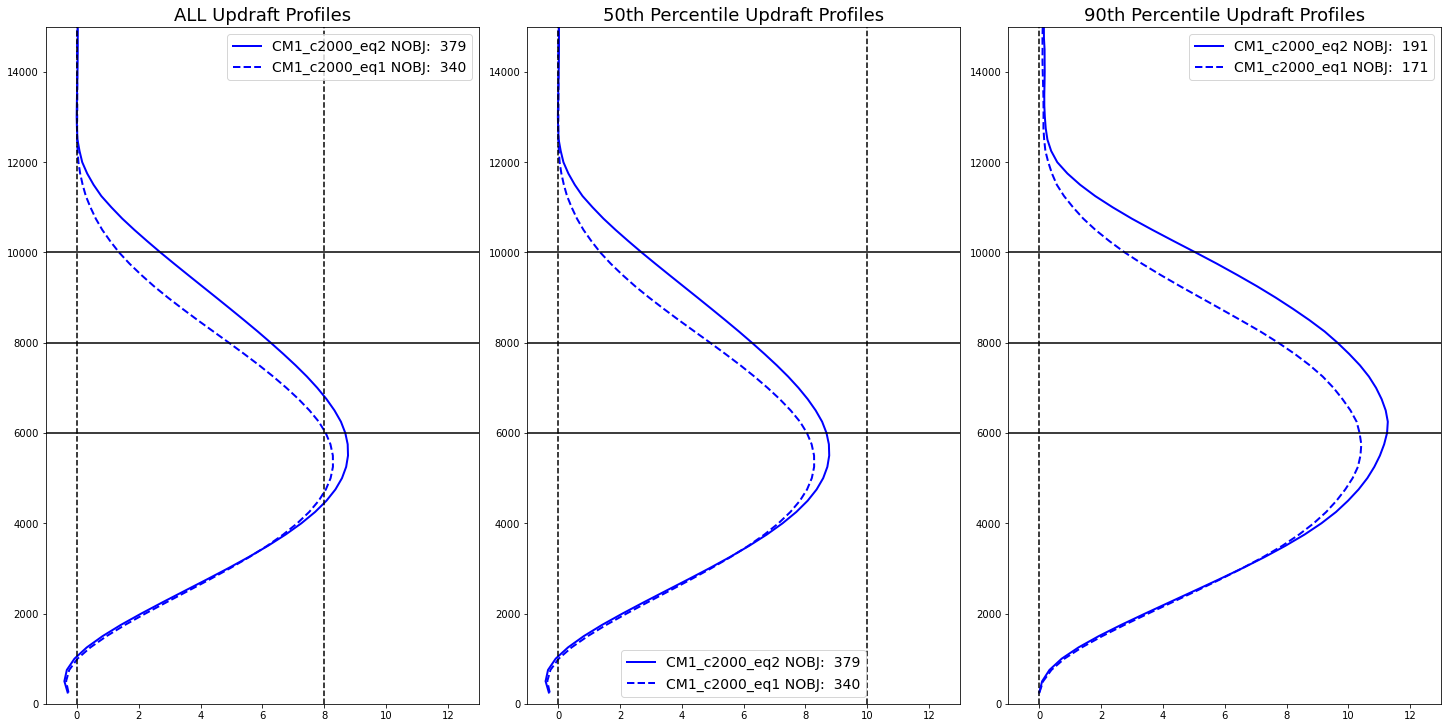

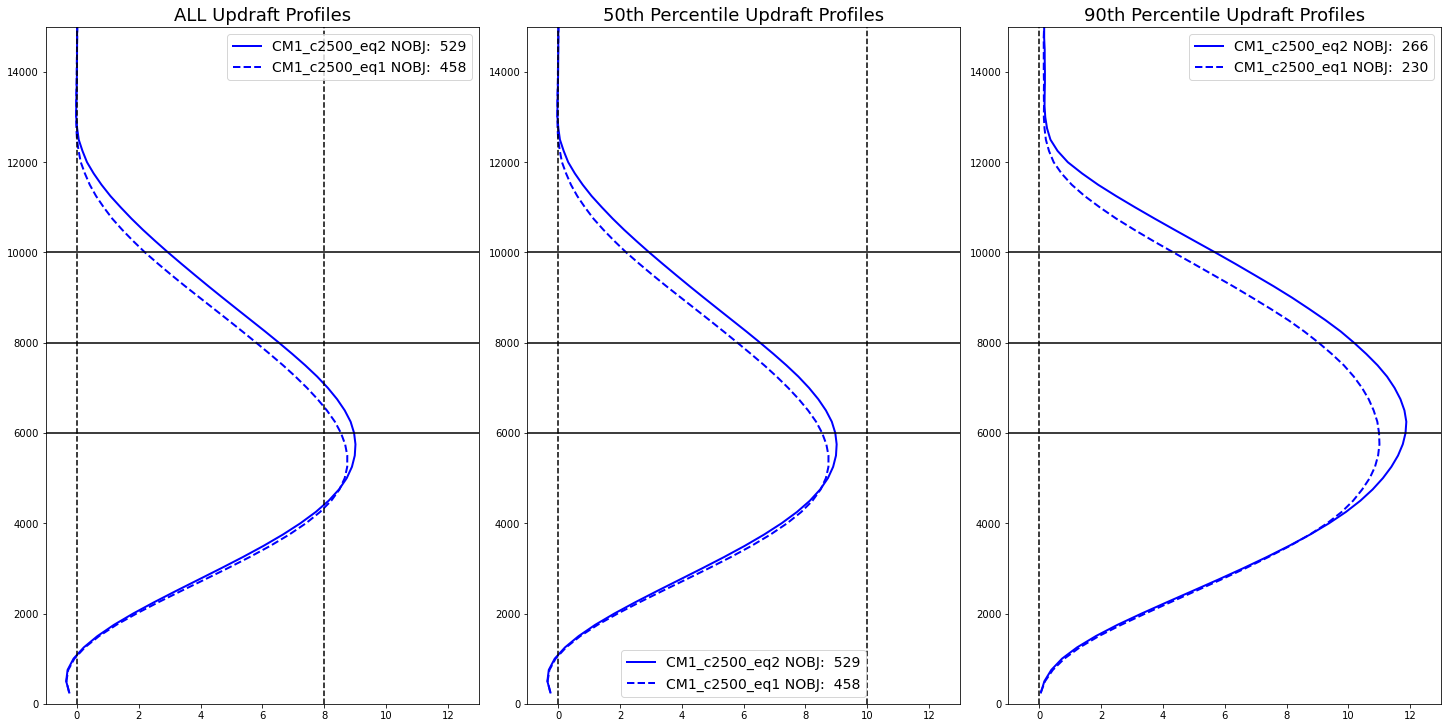

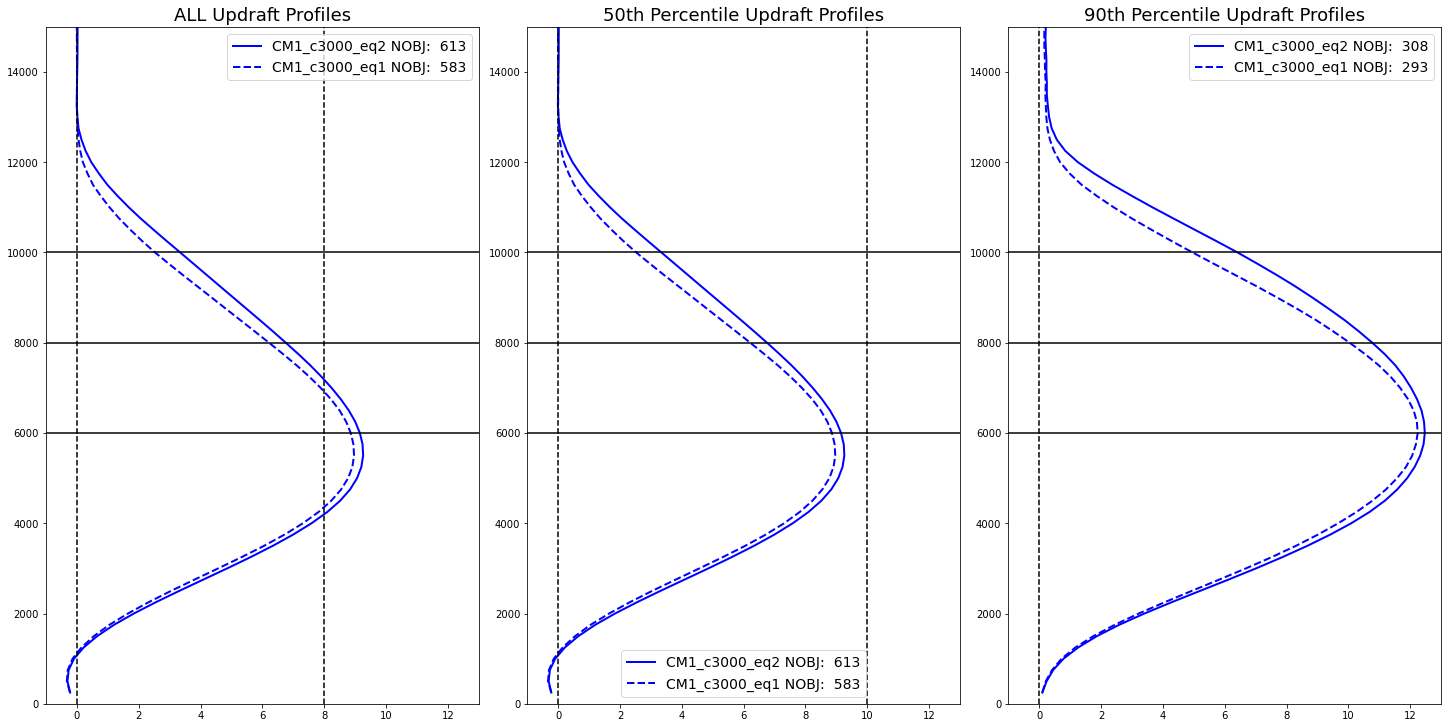

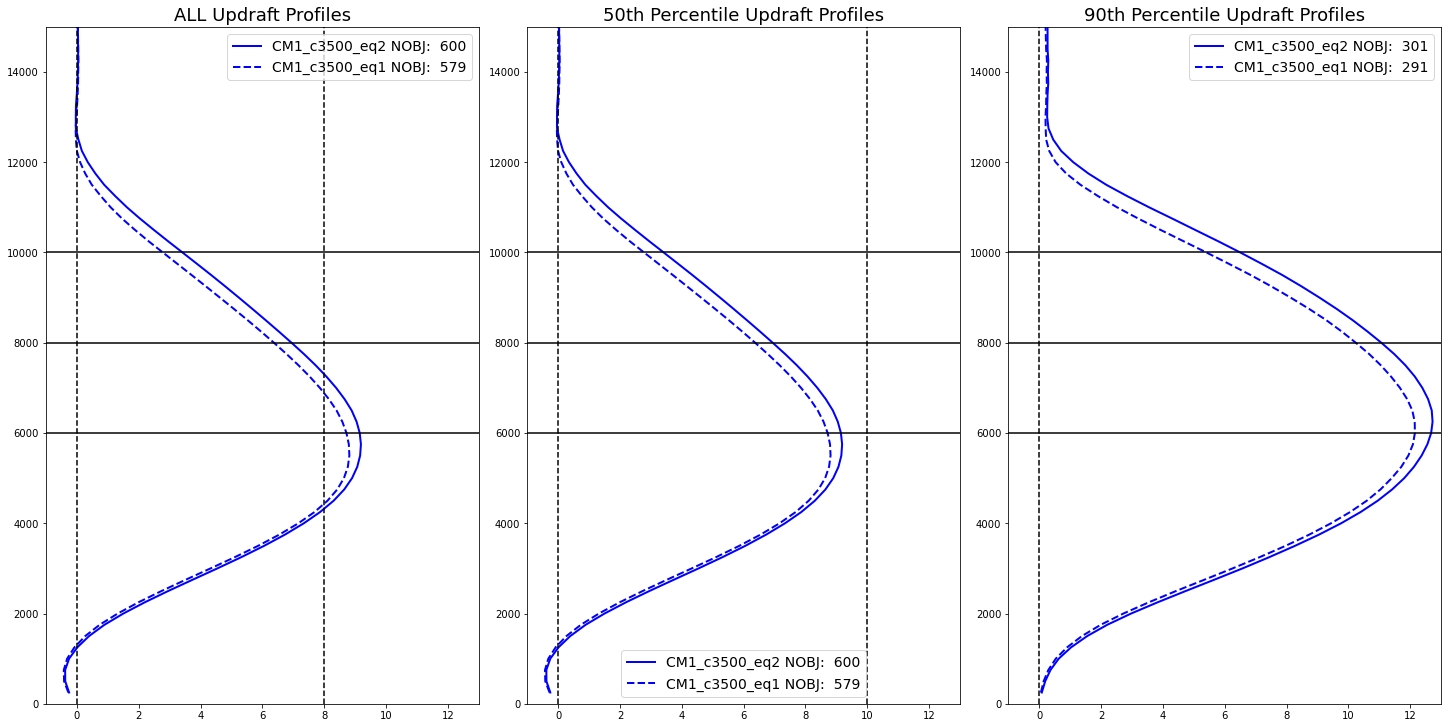

In [21]:
#--------------------------------------------------------------------------------------------
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)
#--------------------------------------------------------------------------------------------
# main

titles = ["ALL Updraft Profiles", "50th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]
xlim   = [13.0, 13.0, 13.0, 13.0]

zhgts = 250. + 250.*np.arange(60)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c1500_thom,     zhgts, n, ax[n], 'b', 'CM1_c1500_eq2')              
    plot_wprofile(cm1_c1500_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c1500_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c2000_thom,     zhgts, n, ax[n], 'b', 'CM1_c2000_eq2')              
    plot_wprofile(cm1_c2000_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c2000_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)
   

#--------------

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c2500_thom,     zhgts, n, ax[n], 'b', 'CM1_c2500_eq2')              
    plot_wprofile(cm1_c2500_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c2500_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)
    
#--------------

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c3000_thom,     zhgts, n, ax[n], 'b', 'CM1_c3000_eq2')              
    plot_wprofile(cm1_c3000_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c3000_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)
    
#--------------

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c3500_thom,     zhgts, n, ax[n], 'b', 'CM1_c3500_eq2')              
    plot_wprofile(cm1_c3500_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c3500_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)